In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rasterio as rio

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set Plot font sizes
SMALL_SIZE = 24
MEDIUM_SIZE = 28
BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

![grs-80.png](grs-80.png)

In [3]:
def ABIangle2LonLat(x, y, H, req, rpol, lon_0_deg):
    '''Find the latitude and longitude (degrees) of point P given x and y, ABI elevation and scanning angle (radians)'''
    
    # intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
    
    # solve for rc on the ellipsoid
    #_rc = c*cos(A) ± √[ a2 - c2 sin2 (A) ]
    # add elevation z to rc
    # compute new rs value
    
    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)
    
    # calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat) #*
    lon = lon_0_deg - np.degrees( np.arctan( Sy / ( H - Sx )) )
    
    return (lon,lat)


In [4]:
def LonLat2ABIangle(lon_deg, lat_deg, z, H, req, rpol, e, lon_0_deg):
    '''Find the ABI elevation (y) and scanning (x) angles (radians) of point P , given a latitude and longitude (degrees)'''
    
    # convert lat and lon from degrees to radians
    lon = np.radians(lon_deg)
    lat = np.radians(lat_deg)
    lon_0 = np.radians(lon_0_deg)
      
    # geocentric latitude
    lat_geo = np.arctan( (rpol**2 / req**2) * np.tan(lat) )

    # geocentric distance to point on the ellipsoid
    _rc = rpol / np.sqrt(1 - (e**2)*(np.cos(lat_geo)**2)) # this is rc if point is on the ellipsoid
    rc = _rc + z # this is rc if the point is offset from the ellipsoid by z (meters)

    # intermediate calculations
    Sx = H - rc * np.cos(lat_geo) * np.cos(lon - lon_0)
    Sy = -rc * np.cos(lat_geo) * np.sin(lon - lon_0)
    Sz = rc * np.sin(lat_geo)
    
    # calculate x and y scan angles
    y = np.arctan( Sz / Sx )
    x = np.arcsin( -Sy / np.sqrt( Sx**2 + Sy**2 + Sz**2 ) )
    
    ## determine if this point is visible to the satellite
    #condition = ( H * (H-Sx) ) < ( Sy**2 + (req**2 / rpol**2)*Sz**2 )
    #if condition == True:
    #    print('Point at {},{} not visible to satellite.'.format(lon_deg,lat_deg))
    #    return (np.nan, np.nan)
    #else:
    #    return (x,y)
    return (x,y)
    


***
#### Demonstrate these functions
To begin, specify the ellipsoid model:

In [5]:
# Values needed for geometry calculations
req = 6378137 #g16_b02.goes_imager_projection.semi_major_axis
rpol = 6356752.31414 #g16_b02.goes_imager_projection.semi_minor_axis
H = 42164160 #g16_b02.goes_imager_projection.perspective_point_height + g16_b02.goes_imager_projection.semi_major_axis
lon_0 = -137.2 #g16_b02.goes_imager_projection.longitude_of_projection_origin
e = 0.0818191910435 # GRS-80 eccentricity

#### Grand Mesa West:
39.0339, -108.2140, 3033 m

In [6]:
lat = 39.0339
lon = -108.2140
z = 3033
print('Starting point lon, lat, z:',lon, lat, z)

# find corresponding angles
x, y = LonLat2ABIangle(lon,lat,z,H,req,rpol,e,lon_0)
print('Scan angle x, y:',x, y)

# use these to go back to our original lon and lat without taking elevation into account
_lon, _lat = ABIangle2LonLat(x,y,H,req,rpol,lon_0)
print('Erroneous lon, lat:',_lon, _lat)

print('Offset (km) (E-W, N-S):',(_lon-lon)*111, (_lat-lat)*111)

Starting point lon, lat, z: -108.214 39.0339 3033
Scan angle x, y: 0.06315553867134631 0.10529065601281326
Erroneous lon, lat: -108.18184331290851 39.06227990426048
Offset (km) (E-W, N-S): 3.5693922671549956 3.150169372912785


Determine what pixel we're in ("2 km" IR pixels are 56 micro-radians across):
![pixel_coords.png](pixel_coords.png)

In [7]:
x_px = x / (56e-6)
y_px = y / (56e-6)


print('Pixel coords relative to origin (x,y):',np.floor(x_px),np.ceil(y_px))


center_x = (np.floor(x_px)-0.5)*(56e-6)
center_y = (np.ceil(y_px)+0.5)*(56e-6)
print('\nThe center of this pixel is at (x,y):',center_x,center_y)

Pixel coords relative to origin (x,y): 1127.0 1881.0

The center of this pixel is at (x,y): 0.063084 0.105364


#### Gaylor Pit, Tuolumne
37.88175, -119.31212, 2811 m

In [8]:
lat = 37.88175
lon = -119.31212
z = 2811
print('Starting point lon, lat, z:',lon, lat, z)

# find corresponding angles
x, y = LonLat2ABIangle(lon,lat,z,H,req,rpol,e,lon_0)
print('Scan angle x, y:',x, y)

# use these to go back to our original lon and lat without taking elevation into account
_lon, _lat = ABIangle2LonLat(x,y,H,req,rpol,lon_0)
print('Erroneous lon, lat:',_lon, _lat)

print('Offset (km) (E-W, N-S):',(_lon-lon)*111, (_lat-lat)*111)

Starting point lon, lat, z: -119.31212 37.88175 2811
Scan angle x, y: 0.041206043100924364 0.10391420176004901
Erroneous lon, lat: -119.29575228202233 37.906318006573315
Offset (km) (E-W, N-S): 1.8168166955200888 2.7270487296383266


In [9]:
x_px = x / (56e-6)
y_px = y / (56e-6)


print('Pixel coords relative to origin (x,y):',np.floor(x_px),np.ceil(y_px))


center_x = (np.floor(x_px)-0.5)*(56e-6)
center_y = (np.ceil(y_px)+0.5)*(56e-6)
print('\nThe center of this pixel is at (x,y):',center_x,center_y)

Pixel coords relative to origin (x,y): 735.0 1856.0

The center of this pixel is at (x,y): 0.041132 0.103964


#### Load a 30m DEM of Tuolumne

In [10]:
dem = xr.open_rasterio('dem.tif')
dem = dem.where(dem!=dem.nodatavals[0])[0,:,:] # replace nodata with nans


In [12]:
for lon_0 in [-75.2, -137.2]:#-80, -90, -100, -110, -120, -130, -137.2]:
    sat = 'Geostationary Orbit at {} Longitude'.format(lon_0)
    if lon_0 == -75.2:
        sat = 'GOES-East'
    if lon_0 == -137.2:
        sat = 'GOES-West'
        
    
    lat = 37.88175
    lon = -119.31212
    z = 2811
    print('Starting point lon, lat, z:',lon, lat, z)

    # find corresponding angles
    x, y = LonLat2ABIangle(lon,lat,z,H,req,rpol,e,lon_0)
    print('Scan angle x, y:',x, y)

    # use these to go back to our original lon and lat without taking elevation into account
    _lon, _lat = ABIangle2LonLat(x,y,H,req,rpol,lon_0)
    print('Erroneous lon, lat:',_lon, _lat)

    print('Offset (km) (E-W, N-S):',(_lon-lon)*111, (_lat-lat)*111)
    
    
    x_px = x / (56e-6)
    y_px = y / (56e-6)


    print('Pixel coords relative to origin (x,y):',np.floor(x_px),np.ceil(y_px))


    center_x = (np.floor(x_px)-0.5)*(56e-6)
    center_y = (np.ceil(y_px)+0.5)*(56e-6)
    print('\nThe center of this pixel is at (x,y):',center_x,center_y)
    
    X, Y = np.meshgrid(dem.x,dem.y)
    Z = dem.values
    abi_grid_x, abi_grid_y = LonLat2ABIangle(X,Y,Z,H,req,rpol,e,lon_0)


    plt.figure(figsize=(15,10))
    plt.plot(abi_grid_x,abi_grid_y,'.',c='k',alpha=0.003)
    plt.plot(x,y,'^',c='k',markersize=23) # location of gaylor pit
    plt.plot(x,y,'^',c='#eaec2c',markersize=20) # location of gaylor pit
    #plt.plot([center_x-28e-6, center_x+28e-6,center_x+28e-6, center_x-28e-6, center_x-28e-6],
    #         [center_y+28e-6, center_y+28e-6,center_y-28e-6, center_y-28e-6, center_y+28e-6],':r') # the pixel we're in
    plt.xlim((x-0.0012,x+0.0004))
    plt.ylim((y-0.0004,y+0.0007))
    plt.title('View of the Tuolumne River Basin from {}'.format(sat))
    plt.xlabel('ABI Azimuth Scan Angle (rad)')
    plt.ylabel('ABI Elevation Scan Angle (rad)')
    plt.savefig('tuolumne_GOES-R_ABI_parallax_30m_{}_GaylorPit_poster.png'.format(str(lon_0)),dpi=300,bbox_inches='tight')
    plt.close()

Starting point lon, lat, z: -119.31212 37.88175 2811
Scan angle x, y: -0.09035872257477835 0.10075904750779954
Erroneous lon, lat: -119.36570903570059 37.90851741595954
Offset (km) (E-W, N-S): -5.948382962766246 2.9711831715089545
Pixel coords relative to origin (x,y): -1614.0 1800.0

The center of this pixel is at (x,y): -0.09041199999999999 0.100828
Starting point lon, lat, z: -119.31212 37.88175 2811
Scan angle x, y: 0.041206043100924364 0.10391420176004901
Erroneous lon, lat: -119.29575228202233 37.906318006573315
Offset (km) (E-W, N-S): 1.8168166955200888 2.7270487296383266
Pixel coords relative to origin (x,y): 735.0 1856.0

The center of this pixel is at (x,y): 0.041132 0.103964


In [ ]:
def draw_px_footprint(dem,xs,ys):
    
    # Make a nan array of the same shape
    dem_array = np.full([dem.shape[0], dem.shape[1]], np.nan)

    # Find upper and lower value of the elevation band we want
    half_width = band_width / 2
    lower = elev_band - half_width
    upper = elev_band + half_width

    # Find the indices in the DEM data that correspond to our elevation band
    elev_idx = np.where( (dem.x > lower) & (dem.x < upper) )

    # Wherever our elevation band criteria is met, set that value to 1 in our elevation band array
    elev_band_array[elev_idx] = 1
    
    # Return the elevation band array
    return elev_band_array

In [ ]:
elev_band_array = draw_elev_band(dem_,xs,ys)

In [138]:
center_x = -0.090692
center_y = 0.100772

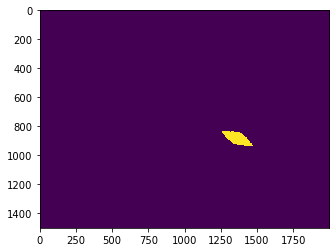

In [136]:
x_cond = (abi_grid_x >= (center_x-(0.5*56e-6))) & (abi_grid_x <= (center_x+(0.5*56e-6)))
y_cond = (abi_grid_y >= (center_y-(0.5*56e-6))) & (abi_grid_y <= (center_y+(0.5*56e-6)))
pixel_of_interest = (x_cond & y_cond)
plt.imshow(pixel_of_interest)

In [123]:
dem.res

(0.0003115924696741881, 0.0003115924696868757)

In [137]:
# Open and write to this new file
with rio.open('goes-pixel-footprint_30m_goeseast.tif', 
              'w', 
              driver='GTiff',
              height=pixel_of_interest.shape[0],
              width=pixel_of_interest.shape[1],
              count=1, 
              dtype='int32',
              nodata=-9999,
              crs=dem.crs, 
              transform=dem.transform) as dst:

    dst.write(pixel_of_interest.astype(int), 1)

In [138]:
lon_0

-75.2